In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [182]:
titanic_df = pd.read_csv('data/train.csv')

In [183]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [184]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<Axes: >

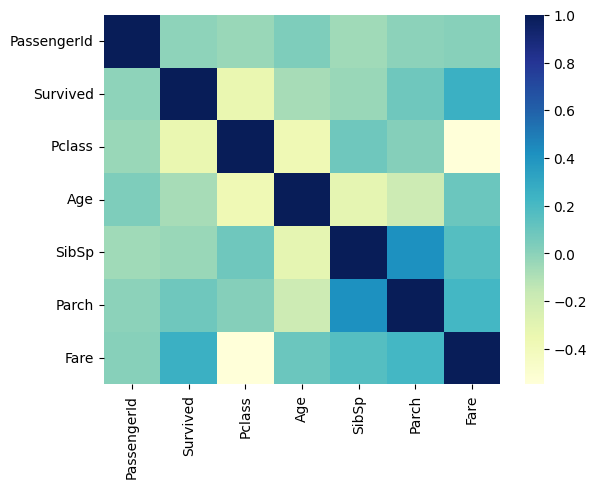

In [185]:
import seaborn as sns

sns.heatmap(titanic_df.corr(numeric_only=True), cmap='YlGnBu')

In [186]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, test_indices in split.split(titanic_df, titanic_df[["Survived", "Pclass", "Sex"]]):
    strat_train_set = titanic_df.loc[train_indices]
    strat_test_set = titanic_df.loc[test_indices]

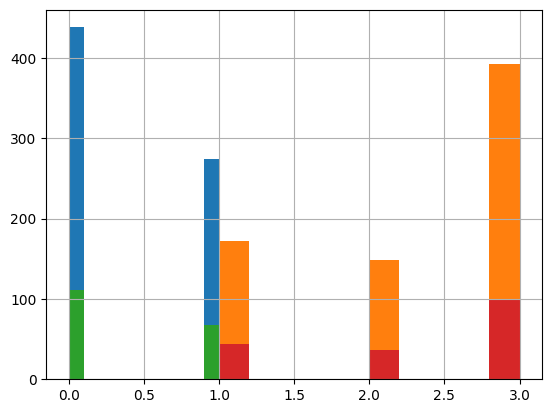

In [187]:
strat_train_set["Survived"].hist()
strat_train_set["Pclass"].hist()
strat_test_set["Survived"].hist()
strat_test_set["Pclass"].hist()

plt.show()


In [188]:
type(strat_train_set)

pandas.core.frame.DataFrame

In [189]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = SimpleImputer(strategy="mean")
        
    def fit(self, X, y=None):
        self.imputer.fit(X[['Age']])
        return self
    
    def transform(self, X):
        X = X.copy()
        X['Age'] = self.imputer.transform(X[['Age']])
        return X

In [190]:
titanic_df["Embarked"].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [191]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder_embarked = OneHotEncoder()
        self.encoder_sex = OneHotEncoder()
    
    def fit(self, X, y=None):
        self.encoder_embarked.fit(X[['Embarked']])
        self.encoder_sex.fit(X[['Sex']])
        return self
    
    def transform(self, X):
        X = X.copy()
        embarked_encoded = self.encoder_embarked.transform(X[['Embarked']]).toarray()
        sex_encoded = self.encoder_sex.transform(X[['Sex']]).toarray()
        
        embarked_df = pd.DataFrame(embarked_encoded, columns=self.encoder_embarked.get_feature_names_out(['Embarked']))
        sex_df = pd.DataFrame(sex_encoded, columns=['Female', 'Male'])
        
        X = pd.concat([X.reset_index(drop=True), embarked_df.reset_index(drop=True), sex_df.reset_index(drop=True)], axis=1)
        return X

        


In [192]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X.drop(['Embarked', 'Name', 'Ticket', 'Cabin', 'Sex', 'Embarked_nan'], axis=1, inplace=True, errors='ignore')
        return X

In [193]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('ageimputer', AgeImputer()), 
                     ('featureencoder', FeatureEncoder()), 
                     ('featuredropper', FeatureDropper())])

In [194]:
strat_train_set = pipeline.fit_transform(strat_train_set)

In [196]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   Embarked_C   712 non-null    float64
 8   Embarked_Q   712 non-null    float64
 9   Embarked_S   712 non-null    float64
 10  Female       712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 66.9 KB


In [197]:
strat_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Female,Male
0,204,0,3,45.500000,0,0,7.2250,1.0,0.0,0.0,0.0,1.0
1,628,1,1,21.000000,0,0,77.9583,0.0,0.0,1.0,1.0,0.0
2,803,1,1,11.000000,1,2,120.0000,0.0,0.0,1.0,0.0,1.0
3,139,0,3,16.000000,0,0,9.2167,0.0,0.0,1.0,0.0,1.0
4,297,0,3,23.500000,0,0,7.2292,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
707,588,1,1,60.000000,1,1,79.2000,1.0,0.0,0.0,0.0,1.0
708,127,0,3,29.921282,0,0,7.7500,0.0,1.0,0.0,0.0,1.0
709,500,0,3,24.000000,0,0,7.7958,0.0,0.0,1.0,0.0,1.0
710,68,0,3,19.000000,0,0,8.1583,0.0,0.0,1.0,0.0,1.0


In [201]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(['Survived'], axis=1)
y = strat_train_set['Survived']

scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()
